### Glove to Graph

This notebook builds a graph by loading a GLoVe embeddings file.

The graph is cut down to a manageable number of edges through the use of a length threshold and a spanning tree. It is guaranteed to be connected, so you can find every word via traversal.

This notebook does compute the full graph, only the first 3000 words.

In [1]:
import graphviz
import numpy as np

from collections import Counter
from tqdm.notebook import tqdm

from scipy.spatial.distance import euclidean
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

from matplotlib import pyplot as plt

In [2]:
#glove_file = '/mnt/Spookley/datasets/glove/glove.840B.300d.txt'
glove_file = '/home/theo/repos/datasets/glove/glove.6B.50d.txt'

w_vecs = {}
end_at = 3000
cur = 0
with tqdm(total=end_at) as pbar:
    with open(glove_file) as fh:
        for line in fh.readlines():
            pbar.update(1)
            toks = line.strip().split()
            word = toks[0]
            # non-words like punctuation marks have entries, but we don't want those
            if not word.isalnum():  
                continue
            try:
                vec = [float(s) for s in toks[1:]]
                w_vecs[word] = vec
                cur += 1
                if cur > end_at: 
                    break
            except Exception as e:
                # some bigrams and trigrams snuck into this dataset. Skip them, not relevant to Semantle.
                pass

  0%|          | 0/2196017 [00:00<?, ?it/s]

In [3]:
print('example words:')
', '.join(list(w_vecs.keys())[:150])

example words:


'the, of, to, and, in, a, for, that, on, is, was, said, with, he, as, it, by, at, from, his, an, be, has, are, have, but, were, not, this, who, they, had, i, which, will, their, or, its, one, after, new, been, also, we, would, two, more, first, about, up, when, year, there, all, out, she, other, people, her, percent, than, over, into, last, some, government, time, you, years, if, no, world, can, three, do, president, only, state, million, could, us, most, against, so, them, what, him, united, during, before, may, since, many, while, where, states, because, now, city, made, like, between, did, just, national, day, country, under, such, second, then, company, group, any, through, china, four, being, down, war, back, off, south, american, minister, police, well, including, team, international, week, officials, still, both, even, high, part, told, those, end, former, these, make, billion, work, our, home, school, party, house'

In [4]:
print('unrelated word dist:', euclidean(w_vecs['increase'], w_vecs['2006']))
print('related word dist:', euclidean(w_vecs['monday'], w_vecs['wednesday']))

unrelated word dist: 4.965471732053058
related word dist: 0.48359979895215266


In [5]:
# make adjacency matrix
words_list = list(w_vecs.keys())
mat = []
for i, wi in enumerate(words_list):
    row = []
    for j, wj in enumerate(words_list):
        row.append(euclidean(w_vecs[wi], w_vecs[wj]))
    mat.append(row)
adj_mat = csr_matrix(mat)
mst = minimum_spanning_tree(adj_mat)

adj matrix edge length distribution


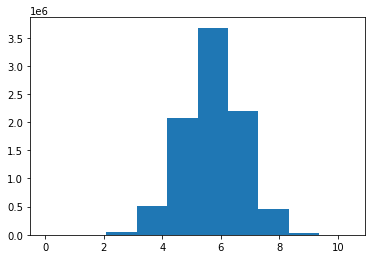

In [6]:
print('adj matrix edge length distribution')
edge_lengths = adj_mat.reshape(np.prod(adj_mat.shape), 1).toarray()
h = plt.hist(edge_lengths)

In [ ]:
# discard all long edges if they're not in the MST.
dist_thresh = 3
for r in range(adj_mat.shape[0]):
    for c in range(adj_mat.shape[1]):
        if mst[r, c] == 0 and adj_mat[r, c] > dist_thresh:
            adj_mat[r, c] = 0


In [ ]:
print('adj matrix edge length distribution after pruning')
edge_lengths = adj_mat.reshape(np.prod(adj_mat.shape), 1).toarray()
nonzero_edge_lengths = edge_lengths[edge_lengths.nonzero()]
print('total edges:', len(nonzero_edge_lengths))
plt.hist(nonzero_edge_lengths)

In [ ]:
# Visualize the neighbors of some word
q_word = 'monday'
idx = words_list.index(q_word)

g = graphviz.Graph()
g.node(q_word)

rs, cs = adj_mat.nonzero()
for i in range(len(rs)):
    if rs[i] == idx:
        neighbor = words_list[cs[i]]
        print(neighbor)
        dist = round(euclidean(w_vecs[q_word], w_vecs[neighbor]), 2)
        g.edge(q_word, neighbor, label=str(dist))
g

In [ ]:
# a few common words have hundreds of neighbors, other words have way less. 
n_neighbors = list(sorted(Counter(rs).values(), reverse=True))
plt.plot(n_neighbors)
plt.ylabel('number of edges') 
print('max edge count:', np.max(n_neighbors))
print('median edge count:', np.median(n_neighbors))
print('min edge count:', np.min(n_neighbors))
n_one_edge = len([x for x in n_neighbors if x==1])
print('There are {} nodes. {} of them have only one edge.'.format(len(n_neighbors), n_one_edge))